# Convolutional AE on MNIST

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
import tensorflow as tf
import tensorflow_quantum as tfq
from hep_VQAE import data_preprocessing as dp
from hep_VQAE import CAE as cae
from tensorflow.keras import layers, losses
import matplotlib.pyplot as plt
from hep_VQAE import utils as ut

plt.rcParams['figure.figsize'] = [10, 5]
import warnings
warnings.filterwarnings('ignore')

2022-07-20 15:57:20.618057: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-20 15:57:20.618076: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/tom/.conda/envs/tfq/lib/python3.9/site-packages/cirq/ops/gateset.py:376: UserWarning: v0.14.1 is the last release `cirq.GlobalPhaseGate` is included by default. If you were relying on this behavior, you can include a `cirq.GlobalPhaseGate` in your `*gates`. If not, then you can ignore this warning. It will be removed in v0.16
  warnings.warn(
2022-07-20 15:57:21.946649: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-20 15:57:21.946672: W tensorflow/

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train/255.0, x_test/255.0

In [3]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


In [4]:
num_data, input_dim_x, input_dim_y = x_train.shape
input_dim = input_dim_x, input_dim_y

In [5]:
ae = cae.Convolutional_Autoencoder1(input_dim, 30)

In [6]:
ae.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0005))

In [7]:
ae.build(x_train.shape)
ae.summary()

Model: "convolutional__autoencoder1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 30)                28494     
                                                                 
 sequential_1 (Sequential)   (12049, 28, 28, 1)        39585     
                                                                 
Total params: 68,079
Trainable params: 68,079
Non-trainable params: 0
_________________________________________________________________


Summary of encoder and decoder model

In [8]:
ae.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 16)          4624      
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 30)                23550     
                                                                 
Total params: 28,494
Trainable params: 28,494
Non-trainable params: 0
_________________________________________________________________


In [9]:
ae.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (12049, 784)              24304     
                                                                 
 reshape (Reshape)           (12049, 7, 7, 16)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (12049, 14, 14, 16)      2320      
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (12049, 28, 28, 32)      12832     
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (12049, 28, 28, 1)        129       
                                                                 
Total params: 39,585
Trainable params: 39,585
Non-trai

In [10]:
x_train_three = x_train[y_train==1]
x_train = x_train[y_train==0]

x_test_three = x_test[y_test==1]
x_test = x_test[y_test==0]

In [11]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
hist = ae.fit(x_train, x_train,
                epochs=25,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[es])

Epoch 1/25
185/185 [==============================] - 5s 23ms/step - loss: 0.3185 - val_loss: 0.2433
Epoch 2/25
185/185 [==============================] - 4s 22ms/step - loss: 0.2328 - val_loss: 0.2348
Epoch 3/25
185/185 [==============================] - 4s 23ms/step - loss: 0.2253 - val_loss: 0.2265
Epoch 4/25
185/185 [==============================] - 5s 25ms/step - loss: 0.2155 - val_loss: 0.2143
Epoch 5/25
185/185 [==============================] - 5s 25ms/step - loss: 0.2054 - val_loss: 0.2060
Epoch 6/25
185/185 [==============================] - 4s 24ms/step - loss: 0.1967 - val_loss: 0.1936
Epoch 7/25
185/185 [==============================] - 4s 21ms/step - loss: 0.1764 - val_loss: 0.1676
Epoch 8/25
185/185 [==============================] - 4s 23ms/step - loss: 0.1577 - val_loss: 0.1529
Epoch 9/25
185/185 [==============================] - 5s 26ms/step - loss: 0.1449 - val_loss: 0.1403
Epoch 10/25
185/185 [==============================] - 5s 26ms/step - loss: 0.1340 - val_lo

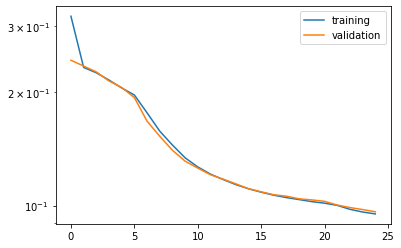

In [12]:
plt.plot(hist.history['loss'], label="training")
plt.plot(hist.history['val_loss'], label="validation")
plt.yscale('log')
plt.legend()

Collapse_metric: 0.895
ssim: 0.863
MAE: 0.0375
normalized MAE: 0.00036


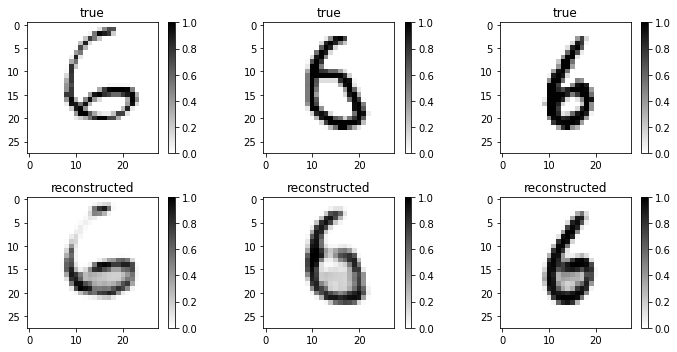

In [13]:
recon = ae.predict(x_test[:500])

ut.eval_recon(x_test[:500], recon)

Median background: 0.0955
Median signal: 0.21
Maximum accuracy: 0.96
AUC: 0.991


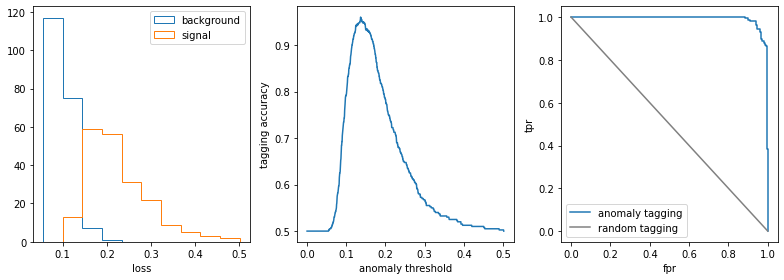

In [14]:
recon_six = ae.predict(x_test[:200])
recon_three = ae.predict(x_test_three[:200])

ut.eval_tagging(x_test[:200], recon_six, x_test_three[:200], recon_three)